# Abstract

This is a simple restatement of the VAE MNist tutorial from the Keras documentation at:

https://www.tensorflow.org/guide/keras/custom_layers_and_models#the_add_loss_method

It was found by looking at this Stackoverflow question where the answerer (obliquely) suggested that there can be issues with feeding in tfvars into loss functions at the last minute, even via Lambdas

https://stackoverflow.com/questions/62766042/inputs-to-eager-execution-function-cannot-be-keras-symbolic-tensors-with-variati

> I've been having the same problem for a long time, but managed to figure it out. The problem is that TF only accepts loss functions which accept (input, output) parameters which are then compared. However, you are computing your (kl_)loss using also mu and sigma, which are basically dense layers. Until tensorflow v2.1 it magically knew what these parameters were and knew how to include/manipulate them, but from then on, you have to be more careful. 

# Layers API

The tutorial is about the layers API. A Layer has, among other things

1. An `__init__()` constructor which absorbs the usual parameters (e.g. `units`)
2. A `call()` method that does the work of the layer: strictly, for neural-networks layers, this is the implementation of the forward pass.
3. A `build()` method called just before the first call to `call()` which can be used to lazily instantiate the tfvars that make the `Layer`. These tfvars can be marked as trainable or not.
4. A `__call__()` method which actually does the work when you do `m = MyLayer(**params); m(x)`. Among other things, this obviously checks does it need to call `build()` and will at some point call `call()`. 
5. An `add_weight()` method is inherited to simplify adding tfvars
6. An `add_loss()` method can be used to add a layer-specific loss. Typically this is the regularlization loss.

You can compose layers together, which is how you can add an activation layer into your `Dense` layer when you use the `activation` parameter.

Or in our case, create a custom sampling layer which keeps track of the KL loss.



# VAE MNIST Example:  Object-Orientated

In [3]:
from typing import NamedTuple, List, Union, Tuple, Optional

import numpy as np
import sys

import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras import metrics

from tensorflow.keras import backend as K  # tensor operations


class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class Encoder(layers.Layer):
    """Maps MNIST digits to a triplet (z_mean, z_log_var, z)."""

    def __init__(self, latent_dim=32, intermediate_dim=64, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation="relu")
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z


class Decoder(layers.Layer):
    """Converts z, the encoded digit vector, back into a readable digit."""

    def __init__(self, original_dim, intermediate_dim=64, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation="relu")
        self.dense_output = layers.Dense(original_dim, activation="sigmoid")

    def call(self, inputs):
        x = self.dense_proj(inputs)
        return self.dense_output(x)


class VariationalAutoEncoder(keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        original_dim,
        intermediate_dim=64,
        latent_dim=32,
        name="autoencoder",
        **kwargs
    ):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        self.add_loss(kl_loss)
        return reconstructed

In [4]:
import tensorflow as tf

original_dim = 784
vae = VariationalAutoEncoder(original_dim, 64, 32)

optimizer = Adam(learning_rate=1e-3)
mse_loss_fn = MeanSquaredError()

loss_metric = metrics.Mean()

(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype("float32") / 255

train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

epochs = 2

# Iterate over epochs.
for epoch in range(epochs):
    print("Start of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, x_batch_train in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            reconstructed = vae(x_batch_train)
            # Compute reconstruction loss
            loss = mse_loss_fn(x_batch_train, reconstructed)
            loss += sum(vae.losses)  # Add KLD regularization loss

        grads = tape.gradient(loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))

        loss_metric(loss)

        if step % 100 == 0:
            print("step %d: mean loss = %.4f" % (step, loss_metric.result()))


11493376/11490434 [==============================] - 1s 0us/step
Start of epoch 0
step 0: mean loss = 0.3845
step 100: mean loss = 0.1276
step 200: mean loss = 0.1003
step 300: mean loss = 0.0899
step 400: mean loss = 0.0848
step 500: mean loss = 0.0813
step 600: mean loss = 0.0791
step 700: mean loss = 0.0775
step 800: mean loss = 0.0763
step 900: mean loss = 0.0752
Start of epoch 1
step 0: mean loss = 0.0749
step 100: mean loss = 0.0742
step 200: mean loss = 0.0737
step 300: mean loss = 0.0732
step 400: mean loss = 0.0729
step 500: mean loss = 0.0725
step 600: mean loss = 0.0722
step 700: mean loss = 0.0719
step 800: mean loss = 0.0716
step 900: mean loss = 0.0714


In [5]:
# Exploit the the fact that VariationalAutoEncoder subclasses Model to make life easier

vae = VariationalAutoEncoder(784, 64, 32)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

vae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())  # 👈 custom loss is added in automatically...
vae.fit(x_train, x_train, epochs=2, batch_size=64)


Epoch 1/2
938/938 [==============================] - 2s 1ms/step - loss: 0.0954
Epoch 2/2
938/938 [==============================] - 1s 1ms/step - loss: 0.0676


# VAE MNIST with the Functional API

In [6]:
original_dim = 784
intermediate_dim = 64
latent_dim = 2

# Define encoder model.
original_inputs = tf.keras.Input(shape=(original_dim,), name="encoder_input")

x = layers.Dense(intermediate_dim, activation="relu")(original_inputs)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()((z_mean, z_log_var))
encoder = tf.keras.Model(inputs=original_inputs, outputs=z, name="encoder")

# Define decoder model.
latent_inputs = tf.keras.Input(shape=(latent_dim,), name="z_sampling")

x = layers.Dense(intermediate_dim, activation="relu")(latent_inputs)
outputs = layers.Dense(original_dim, activation="sigmoid")(x)
decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name="decoder")

# Define VAE model.
outputs = decoder(z)
vae = tf.keras.Model(inputs=original_inputs, outputs=outputs, name="vae")

# Add KL divergence regularization loss.
kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
vae.add_loss(kl_loss)  # 👈 Using this seems to be the key to avoiding losing graph connection in loss fn.

# Train.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
vae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
vae.fit(x_train, x_train, epochs=3, batch_size=64)


Epoch 1/3
938/938 [==============================] - 1s 1ms/step - loss: 0.1116
Epoch 2/3
938/938 [==============================] - 1s 1ms/step - loss: 0.0675
Epoch 3/3
938/938 [==============================] - 1s 1ms/step - loss: 0.0674


In [7]:
import matplotlib.pyplot as plt 
import numpy as np

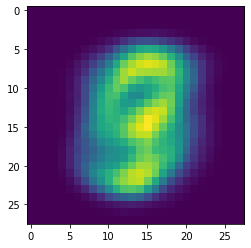

In [8]:
plt.imshow(
  np.squeeze(
    decoder.predict(
      np.array(
        [[-2, -2]]
      )
    )
  ).reshape((28, 28))
)